# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.84MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.93MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


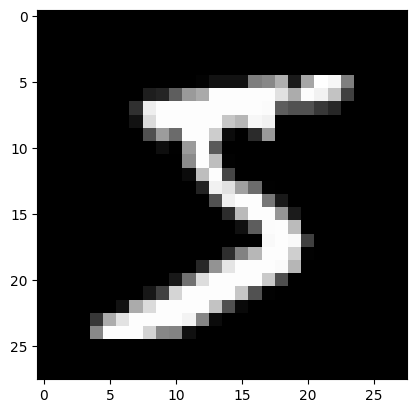

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [7]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 4592.981165885925
Epoch   1 | Loss: 2509.201806306839
Epoch   2 | Loss: 1787.3266285061836
Epoch   3 | Loss: 1399.0115184783936
Epoch   4 | Loss: 1178.7243893742561
Epoch   5 | Loss: 1041.094489067793
Epoch   6 | Loss: 945.3465427458286
Epoch   7 | Loss: 875.3829755485058
Epoch   8 | Loss: 818.8983617722988
Epoch   9 | Loss: 771.9835598170757
Epoch  10 | Loss: 728.1790100336075
Epoch  11 | Loss: 694.7963078916073
Epoch  12 | Loss: 660.9991959035397
Epoch  13 | Loss: 634.2663460075855
Epoch  14 | Loss: 610.0653198808432
Epoch  15 | Loss: 585.0731422901154
Epoch  16 | Loss: 564.5927057862282
Epoch  17 | Loss: 544.6631497442722
Epoch  18 | Loss: 525.2609236836433
Epoch  19 | Loss: 505.51896642148495
Epoch  20 | Loss: 491.3540384322405
Epoch  21 | Loss: 477.9222260862589
Epoch  22 | Loss: 462.0644992887974
Epoch  23 | Loss: 449.0516777038574
Epoch  24 | Loss: 437.57233779132366
Epoch  25 | Loss: 425.5715845823288
Epoch  26 | Loss: 412.6004212424159
Epoch  27 | Loss: 400.0

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [23]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[4.8415]], device='cuda:0', grad_fn=<ReluBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

# [1주차] 기본과제 - MNIST를 분류 모델로 학습하기

# Step 1: Test 데이터셋 생성

In [13]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [14]:
# 확인

In [20]:
print(len(testset))
images, labels = next(iter(testloader))
print(images.shape, labels.shape)

10000
torch.Size([64, 1, 28, 28]) torch.Size([64])


# Step 2. CrossEntropyLoss로 바꾸기

In [25]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

# 손실 함수 정의 변경
loss_fn = nn.CrossEntropyLoss()


In [26]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')
optimizer = SGD(model.parameters(), lr=lr)

n_epochs = 100

for epoch in range(n_epochs):
    total_loss = 0.
    for inputs, labels in trainloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        labels = labels.long()

        model.zero_grad()
        preds = model(inputs)

        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2132.6349251270294
Epoch   1 | Loss: 2070.767764568329
Epoch   2 | Loss: 1972.1258002519608
Epoch   3 | Loss: 1811.897225022316
Epoch   4 | Loss: 1580.9059919118881
Epoch   5 | Loss: 1322.4909065961838
Epoch   6 | Loss: 1111.6843964457512
Epoch   7 | Loss: 969.710176050663
Epoch   8 | Loss: 874.8815505504608
Epoch   9 | Loss: 807.4331187307835
Epoch  10 | Loss: 756.6156152486801
Epoch  11 | Loss: 716.7554951012135
Epoch  12 | Loss: 684.4822281002998
Epoch  13 | Loss: 657.8771381378174
Epoch  14 | Loss: 635.5138416588306
Epoch  15 | Loss: 616.6234413683414
Epoch  16 | Loss: 600.3421022891998
Epoch  17 | Loss: 586.1884736716747
Epoch  18 | Loss: 573.8467253595591
Epoch  19 | Loss: 563.0659447014332
Epoch  20 | Loss: 553.2857710421085
Epoch  21 | Loss: 544.8480432629585
Epoch  22 | Loss: 537.2745437175035
Epoch  23 | Loss: 530.0941373705864
Epoch  24 | Loss: 523.8025459647179
Epoch  25 | Loss: 518.0930767506361
Epoch  26 | Loss: 512.8923438936472
Epoch  27 | Loss: 508.10

In [28]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드로 설정 (일관된 추론 결과를 보장)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    model.train()  # 다시 학습 모드로 복귀
    return acc / cnt

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.

    for inputs, labels in trainloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        labels = labels.long()

        model.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 정확도 측정
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 384.4446 | Train Acc: 0.8631 | Test Acc: 0.8650
Epoch   1 | Loss: 383.6011 | Train Acc: 0.8635 | Test Acc: 0.8647
Epoch   2 | Loss: 382.4135 | Train Acc: 0.8638 | Test Acc: 0.8643
Epoch   3 | Loss: 381.7182 | Train Acc: 0.8640 | Test Acc: 0.8651
Epoch   4 | Loss: 380.6257 | Train Acc: 0.8643 | Test Acc: 0.8658
Epoch   5 | Loss: 379.7407 | Train Acc: 0.8648 | Test Acc: 0.8656
Epoch   6 | Loss: 378.7234 | Train Acc: 0.8648 | Test Acc: 0.8665
Epoch   7 | Loss: 377.6666 | Train Acc: 0.8649 | Test Acc: 0.8662
Epoch   8 | Loss: 376.7655 | Train Acc: 0.8652 | Test Acc: 0.8658
Epoch   9 | Loss: 376.0518 | Train Acc: 0.8656 | Test Acc: 0.8663
Epoch  10 | Loss: 375.1139 | Train Acc: 0.8657 | Test Acc: 0.8662
Epoch  11 | Loss: 373.8093 | Train Acc: 0.8660 | Test Acc: 0.8660
Epoch  12 | Loss: 372.9824 | Train Acc: 0.8661 | Test Acc: 0.8665
Epoch  13 | Loss: 372.3382 | Train Acc: 0.8663 | Test Acc: 0.8659
Epoch  14 | Loss: 371.4092 | Train Acc: 0.8666 | Test Acc: 0.8668
Epoch  15 

In [ ]:
plot_acc(train_accs, test_accs)